# <center>Lab Machine Learning 4</center>

## <center>Souaybou Bagayoko</center>
### <center> Semester 2, Nr: 303189 </center>

 

### <center> Data cleaning and selection </center>
Classification dataset
Tic Tac Toe:
You are required to pre-process given datasets.
1. Convert any non-numeric values to numeric values. For example you can replace a country name with an integer value or more appropriately use hot-one encoding. [Hint: use hashmap (dict) or pandas.get dummies]. Please explain your solution.
2. This dataset is unbalanced, (show how we can confirm this). Explain what is stratified sampling and Implement a stratified sampler.
3. Split the data into a train(80%) and test(20%). 

***Numerical conversion procedure***
I will use hot-one encoding using pandas get_dummies function. 
Each columns except the Label contains three possible categorical data: {x,o,b}. So in each square of the column there will be 0 or 1 encodeg. I choose the b as the baseline as to avoid The Dummy variable trap. A usefull information about The Dummy variable trap can be found https://www.geeksforgeeks.org/ml-dummy-variable-trap-in-regression-models/.
In the Machine learning lecture on Friday 22.11, the professor mentioned that, throwing out a column as mention abave is not one will, in the sense that when we apply the regularisation factor it won't work. 


In [1]:
# Data reading 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline


colum = ['top-left-square','top-middle-square','top-right-square','middle-left-square','middle-middle-square',\
             'middle-right-square','bottom-left-square','bottom-middle-square','bottom-right-square','Class']
data = pd.read_csv('tic-tac-toe.data', names= colum)


To Verify wethere the data is unbalance or not. I will count the data according to class 


In [2]:
data['Class'].value_counts()

positive    626
negative    332
Name: Class, dtype: int64

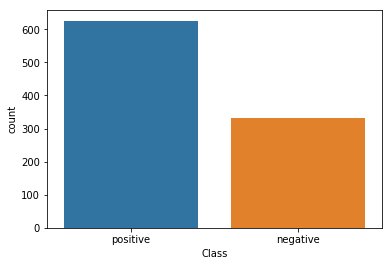

In [3]:
sns.countplot(x='Class', data=data)     

In [4]:
# see that the possitve class is twice larger than the negative one

### Stratifying the Data

Stratifying means here to split the data, so that is contain an even number of each class of the data set 

Mein Stratifying strategie:
    given that the data is unbanlance, I will make sure in the Training there is an even number of each class. In this Case we positive = 626 and negative 332
    Taining data = 80 % of 332 positive + 80 % of 332 negative
    Test data    = 20 % of 332 positive + 20 % of 332 negative + the rest of the positive 

In [5]:
# data partitoining 
def data_split_index (data, percentage, seed):
    train = data.sample(frac=percentage/100, random_state=seed) # taking the percentage of t
                                                                #the shuffle  data 
    tes = data.drop(train.index)                                # puttint the rest inton the 
                                                                #test data  
    return train, tes

groupe = 'Class'
Classe  = data.groupby(groupe)
count  = data[groupe].value_counts()
min_   = min(count.values)
a = 0
for g, _ in Classe:
    if count[g] > min_:
        g = data[data[groupe]==g].sample(frac=1)[:min_] # I select the number fix number of stradum 
    else: 
        g = data[data[groupe]==g]

    if a == 0:  
        train, tes = data_split_index(g,80,50)
    else :
        train_new, tes_new = data_split_index(g,80,50)
        train = pd.concat([train, train_new], axis=0)
        tes   = pd.concat([tes, tes_new], axis=0)
    a +=1
# I put the rest of the data into the tes data 
rest = data.drop(train.index)
rest.drop(tes.index, inplace=True)
tes   = pd.concat([tes, rest], axis=0)

In [6]:
X_train  = pd.get_dummies(train.drop('Class',axis=1)).values
X_tes    = pd.get_dummies(tes.drop('Class',axis=1)).values
Class_train  = pd.get_dummies(train.Class, drop_first=True)
Class_tes    = pd.get_dummies(tes.Class, drop_first=True)
Y_train  = Class_train.values
Y_tes    = Class_tes.values

### 2 Logistic Regression

In [7]:


def sigmoid(a):
    return 1.0 / (1 + np.exp(-a))

def loss_likelyhood(X, Y, btha):
    tmp = np.dot(X, btha)
    return np.sum((Y*tmp - np.log(1+np.exp(tmp))))

def partial(x, y,y_hat):
     
    return np.dot(x.T, (y-y_hat))
        

def learn_logreg_GA(x,y, mu,max_iter, thresh, intercep = False, btha_0=None):
    
    if intercep:                                     #adding the intercep to the X 
        ones = np.ones(x.shape[0]).reshape(-1,1)
        x    = np.hstack([ones, x])
        
    if btha_0  == None:
        btha_0 = np.zeros(x.shape[1]).reshape(-1,1)
    to_plot = {}
    logloss = {}
    for t in range(max_iter):
        loss_0   = loss_likelyhood(x,y,btha_0)
        logloss[t] = loss_0
        y_hat    = sigmoid(np.matmul(x, btha_0))
        grad     =  partial(x,y,y_hat)
        btha_next= btha_0 + mu*grad
        loss_nex = loss_likelyhood(x,y, btha_next)
        to_plot[t] = abs(loss_nex - loss_0)
        if  loss_nex - loss_0 < thresh:
            return btha_0, to_plot, logloss
        
        btha_0   = btha_next
        
        
    return btha_0, to_plot, logloss

 

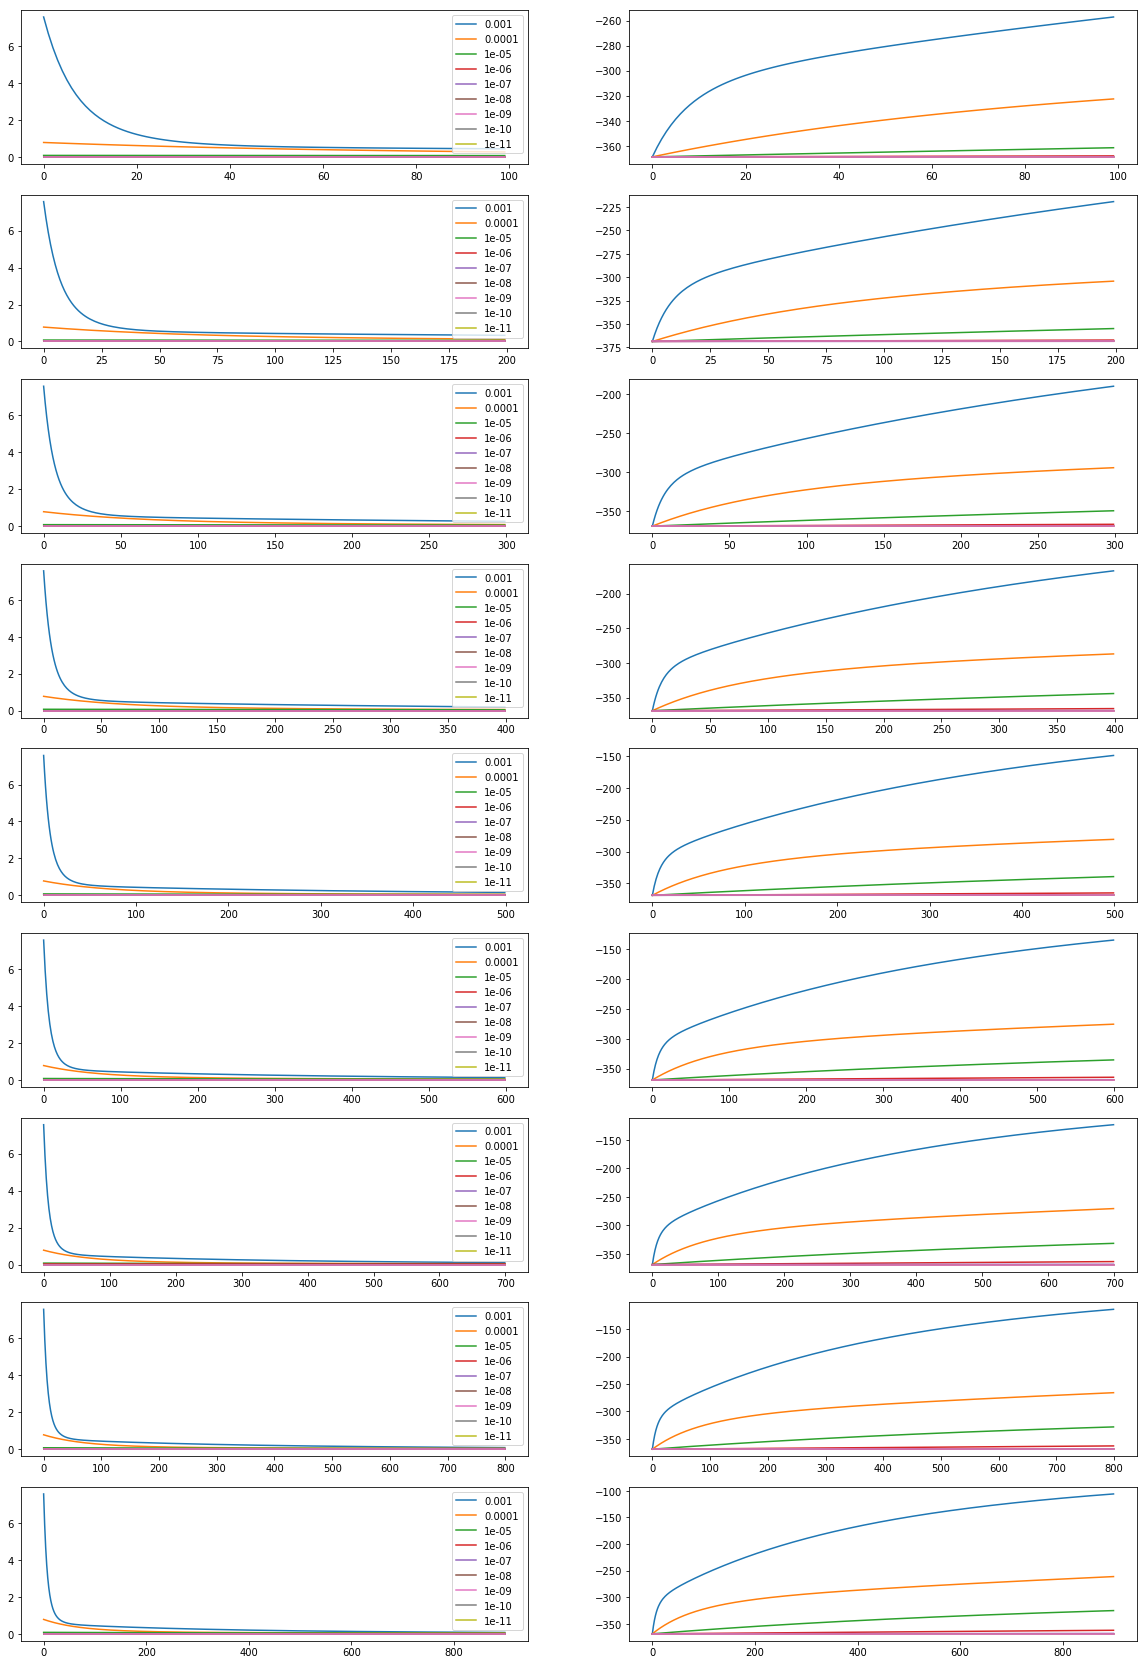

In [8]:
#ploting the resul 

fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(20,30))
color = ['red','green','blue']
t = 9 
for max_iter in range(100, 1000, 100):
    mu = [10**-x for x in range(3,12)]
    for m in mu:
        weights,toplot, loss = learn_logreg_GA(x = X_train ,y=Y_train, mu=m,max_iter=max_iter, \
                                  thresh=10**-6, intercep=True)
        lists = sorted(toplot.items()) 
        list1 = sorted(loss.items()) 
        x, y = zip(*lists)
        x1, y1 = zip(*list1)

        ax[9-t][0].plot(x, y, label=m)
        ax[9-t][1].plot(x1, y1)
        ax[9-t][0].legend(loc='best')
    t -=1


Explanation:
We can notive a decreasing difference between the f(xt) and f(xt-1) and an encreasing logloss 

In [9]:
# Line search 
def backtracking(x,y, btha, loss, grad, alpha=0.2, b=0.5):
    mu =1 
    while loss(x,y,(btha + mu*grad)) < loss(x,y,btha)+alpha*mu*np.dot(grad.T, grad):
        mu *=b
    return mu
    

def sigmoid(a):
    return 1.0 / (1 + np.exp(-a))

def loss_likelyhood(X, Y, btha):
    tmp = np.dot(X, btha)
    return np.sum((Y*tmp - np.log(1+np.exp(tmp))))


def learn_logreg_GA_bactrack(x,y, mu,max_iter, thresh, intercep = False, btha_0=None,alpha=0.2,bt=0.5):
    
    if intercep:                                     #adding the intercep to the X 
        ones = np.ones(x.shape[0]).reshape(-1,1)
        x    = np.hstack([ones, x])
        
    if btha_0 == None:
        btha_0 = np.zeros(x.shape[1]).reshape(-1,1)
    to_plot = {}
    logloss = {}
    for t in range(max_iter):
        loss_0 = loss_likelyhood(x,y,btha_0)
        logloss[t] = loss_0
        y_hat     = sigmoid(np.matmul(x, btha_0))
        grad      = np.dot(x.T, (y-y_hat))
        mu        = backtracking(x,y, btha_0,loss_likelyhood, grad, alpha, bt)
        btha_next = btha_0 + mu*grad
        loss_nex  = loss_likelyhood(x,y, btha_next)
        to_plot[t] = abs(loss_nex - loss_0)
        if loss_nex - loss_0 < thresh:
            print("converge at iteration", t)
            return btha_0 ,to_plot, logloss
        
        btha_0    = btha_next
        
        
    return btha_0 ,to_plot, logloss



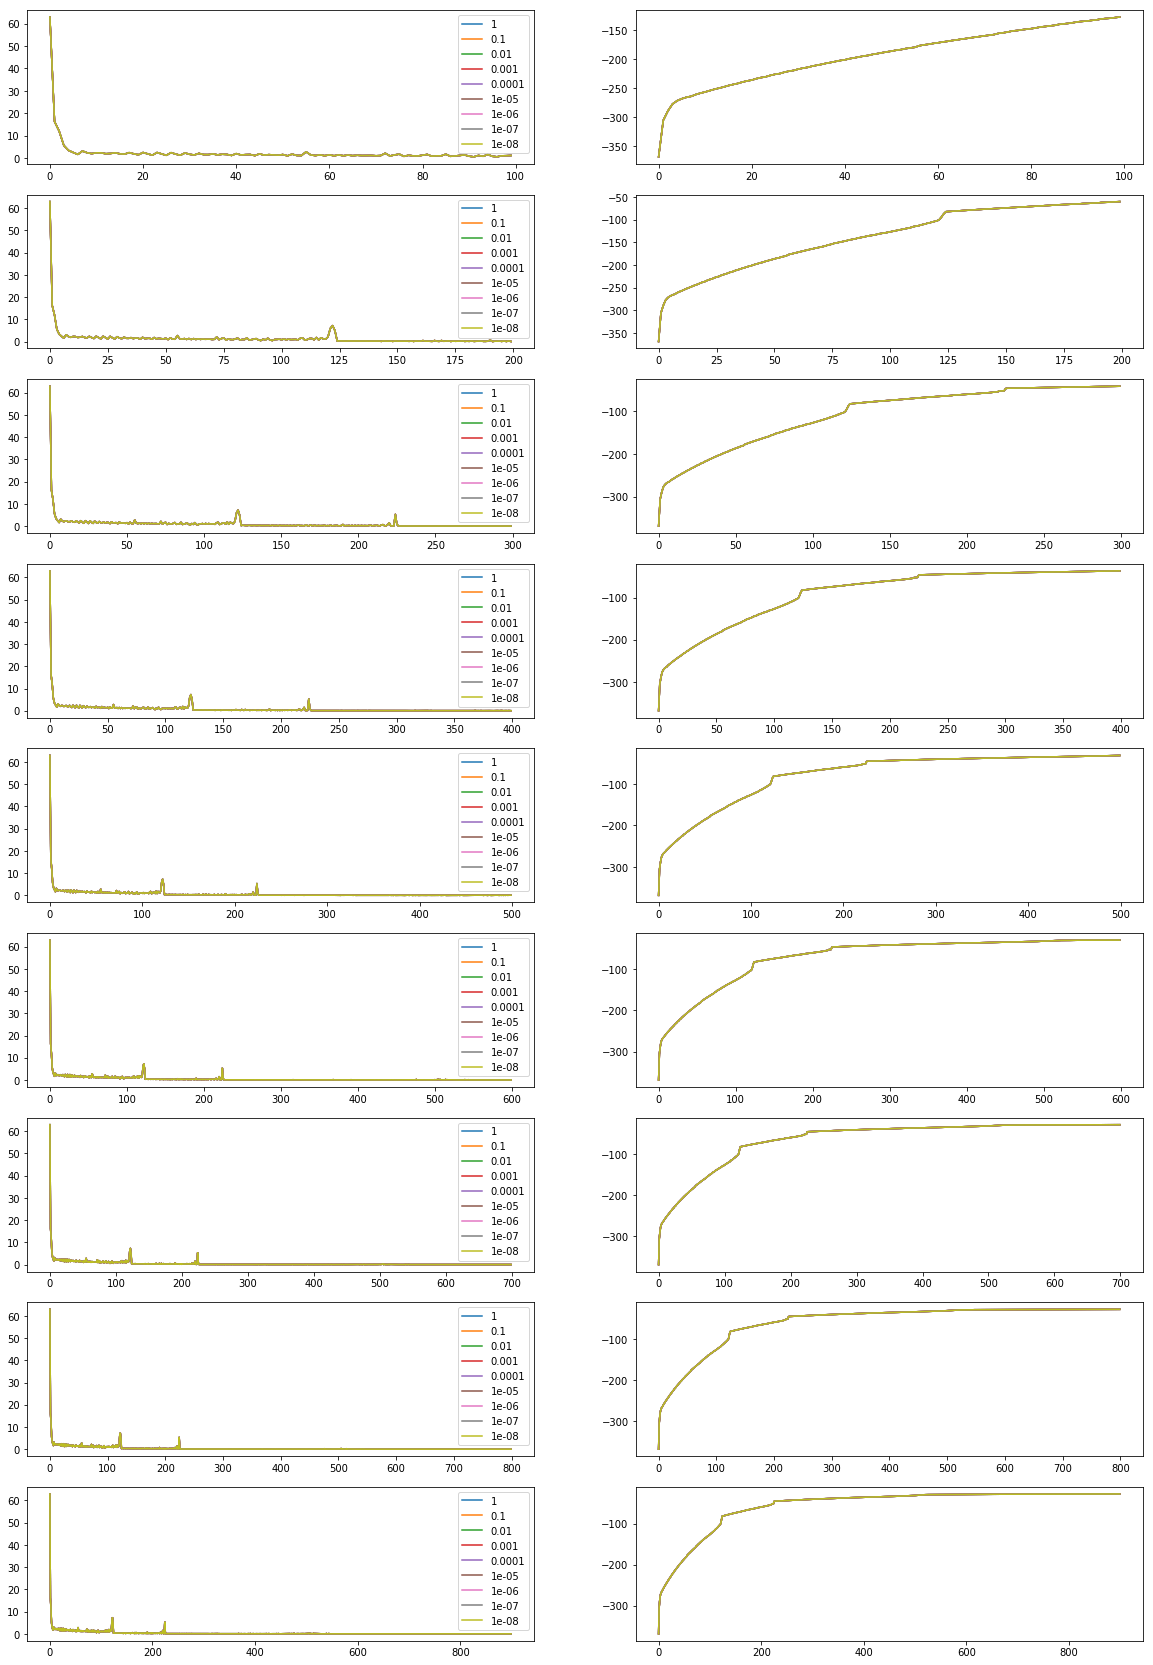

In [10]:
# Using a back backtraking 
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(20,30))
color = ['red','green','blue']
t = 9 
for max_iter in range(100, 1000, 100):
    mu = [10**-x for x in range(9)]
    for m in mu:
        weight1 ,toplot1, loss1 = learn_logreg_GA_bactrack(x = X_train ,y=Y_train, mu=m,max_iter=max_iter, \
                                  thresh=10**-6, intercep=True)
        lists = sorted(toplot1.items()) 
        list1 = sorted(loss1.items()) 
        x, y = zip(*lists)
        x1, y1 = zip(*list1)

        ax[9-t][0].plot(x, y, label=m)
        ax[9-t][1].plot(x1, y1)
        ax[9-t][0].legend(loc='best')
    t -=1

### using bolddriver

In [17]:
def bolddriver(x, y, btha,loss, grad, mu_old ):
    mu = mu_old*1.1
    while loss(x,y,btha) - loss(x,y,(btha + mu*grad)) > 0:
        
        mu = mu*0.5
    return mu


def learn_logreg_GA_bold(x,y, mu,max_iter, thresh, intercep = False, btha_0=None,alpha=0.2,bt=0.5):
    
    if intercep:                                     #adding the intercep to the X 
        ones = np.ones(x.shape[0]).reshape(-1,1)
        x    = np.hstack([ones, x])
        
    if btha_0 == None:
        btha_0 = np.zeros(x.shape[1]).reshape(-1,1)
    to_plot = {}
    logloss = {}
    for t in range(max_iter):
        loss_0 = loss_likelyhood(x,y,btha_0)
        logloss[t] = loss_0 
        y_hat     = sigmoid(np.matmul(x, btha_0))
        grad      = partial(x,y,y_hat)
        
        mu        = bolddriver(x,y, btha_0,loss_likelyhood, grad, mu)
        btha_next = btha_0 + mu*grad
        loss_nex  = loss_likelyhood(x,y, btha_next)
        to_plot[t] = abs(loss_nex - loss_0)
        if  loss_nex - loss_0 < thresh:
            print("iterat", t)
            return btha_0, to_plot, logloss
        
        btha_0    = btha_next
        
        
    return btha_0, to_plot, logloss


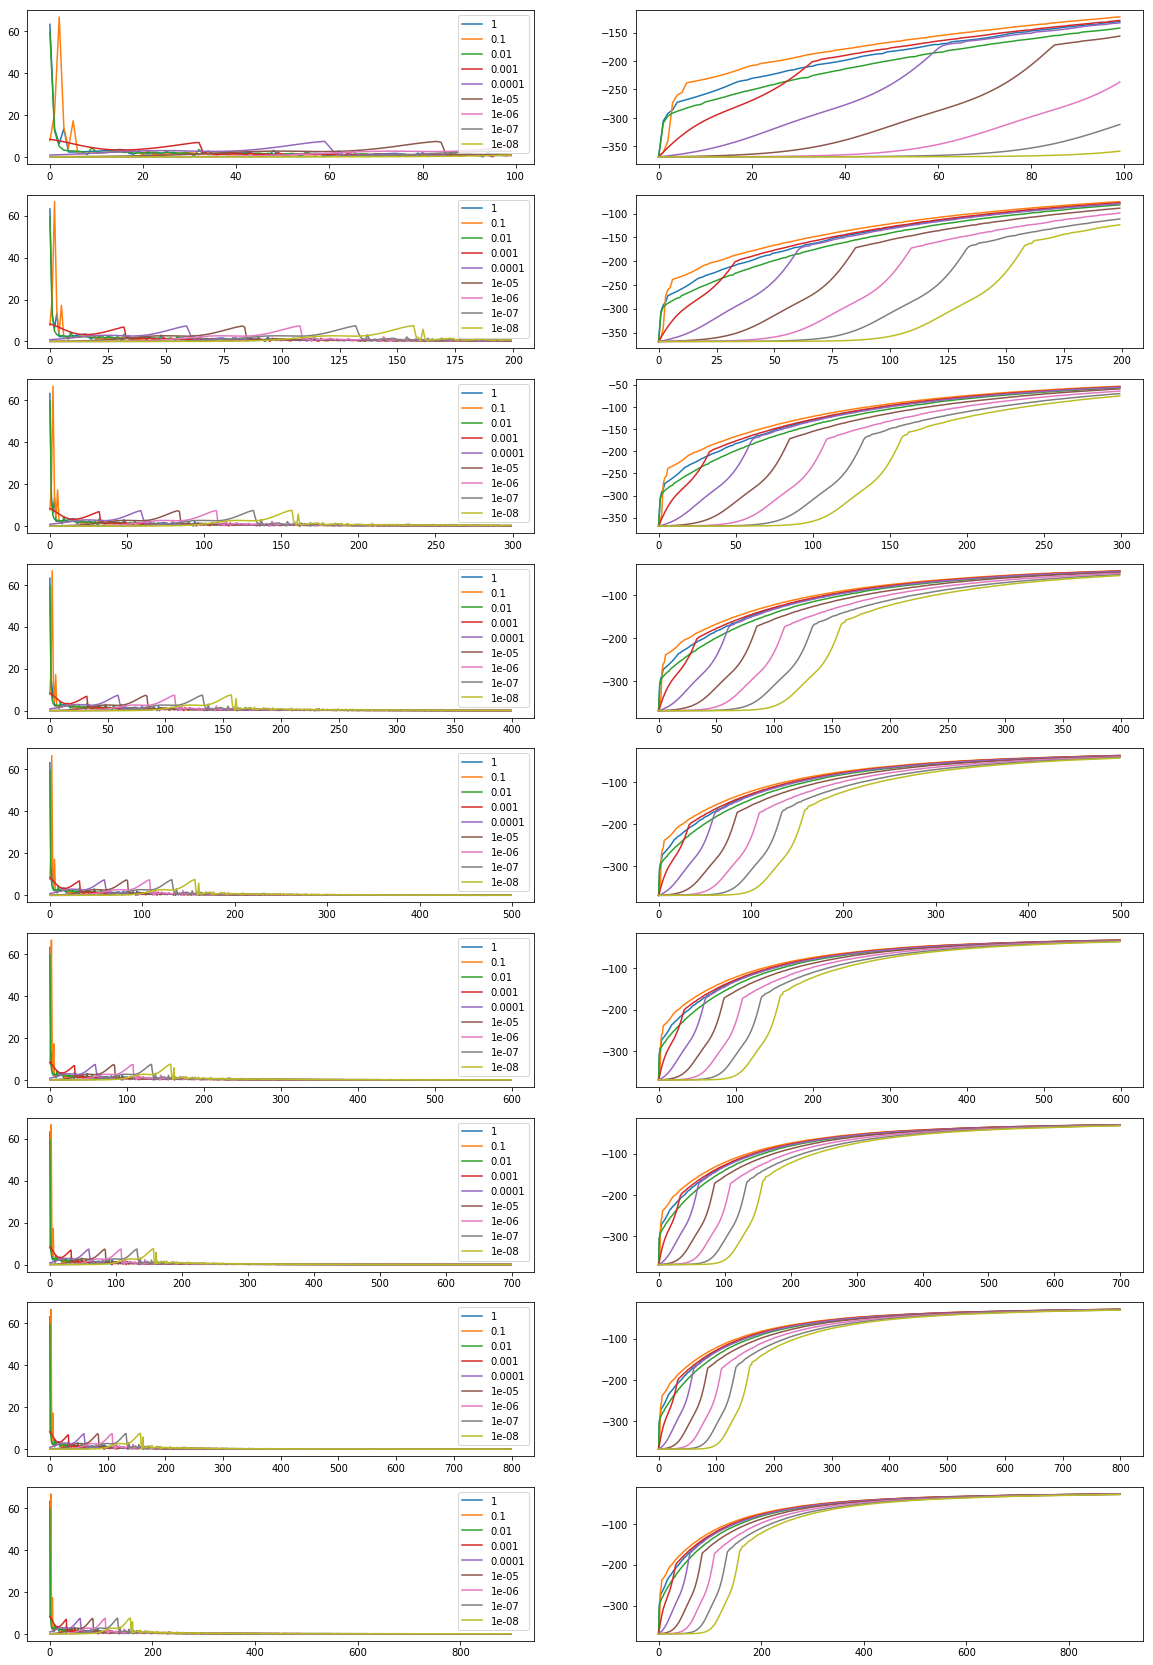

In [18]:
# Using a back boldriver stepsize controller  
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(20,30))
color = ['red','green','blue']
t = 9 
for max_iter in range(100, 1000, 100):
    mu = [10**-x for x in range(9)]
    for m in mu:
    
        weight2 ,toplot2, loss2 = learn_logreg_GA_bold(x = X_train ,y=Y_train, mu=m,max_iter=max_iter, \
                                  thresh=10**-6, intercep=True)
        lists = sorted(toplot2.items()) 
        list1 = sorted(loss2.items()) 
        x, y = zip(*lists)
        x1, y1 = zip(*list1)

        ax[9-t][0].plot(x, y, label=m)
        ax[9-t][1].plot(x1, y1)
        ax[9-t][0].legend(loc='best')
    t -=1

### Using Adagrad

In [16]:
def adagrad(G, grad, mu_old,eps=10**-10):
    G = G + np.multiply(grad,grad)
    mu = mu_old/(np.sqrt(G)+eps)
    return mu, G


def learn_logreg_GA_adag(x,y, mu,max_iter, thresh, intercep = False, btha_0=None,alpha=0.2,bt=0.5):
    
    if intercep:                                     #adding the intercep to the X 
        ones = np.ones(x.shape[0]).reshape(-1,1)
        x    = np.hstack([ones, x])
        
    if btha_0 == None:
        btha_0 = np.zeros(x.shape[1]).reshape(-1,1)
    to_plot = {}
    logloss = {}
    G = 0
    for t in range(max_iter):
        loss_0 = loss_likelyhood(x,y,btha_0)
        logloss[t] = loss_0 
        y_hat     = sigmoid(np.matmul(x, btha_0))
        grad      = partial(x,y,y_hat)
        mu, G     = adagrad(G,grad, mu)
        btha_next = btha_0 + mu*grad
        loss_nex  = loss_likelyhood(x,y, btha_next)
        to_plot[t] = abs(loss_nex - loss_0)
        if  loss_nex - loss_0 < thresh:
            print("iterat", t)
            return btha_0, to_plot, logloss
        
        btha_0    = btha_next
        
        
    return btha_0, to_plot, logloss



iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 0
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1
iterat 1


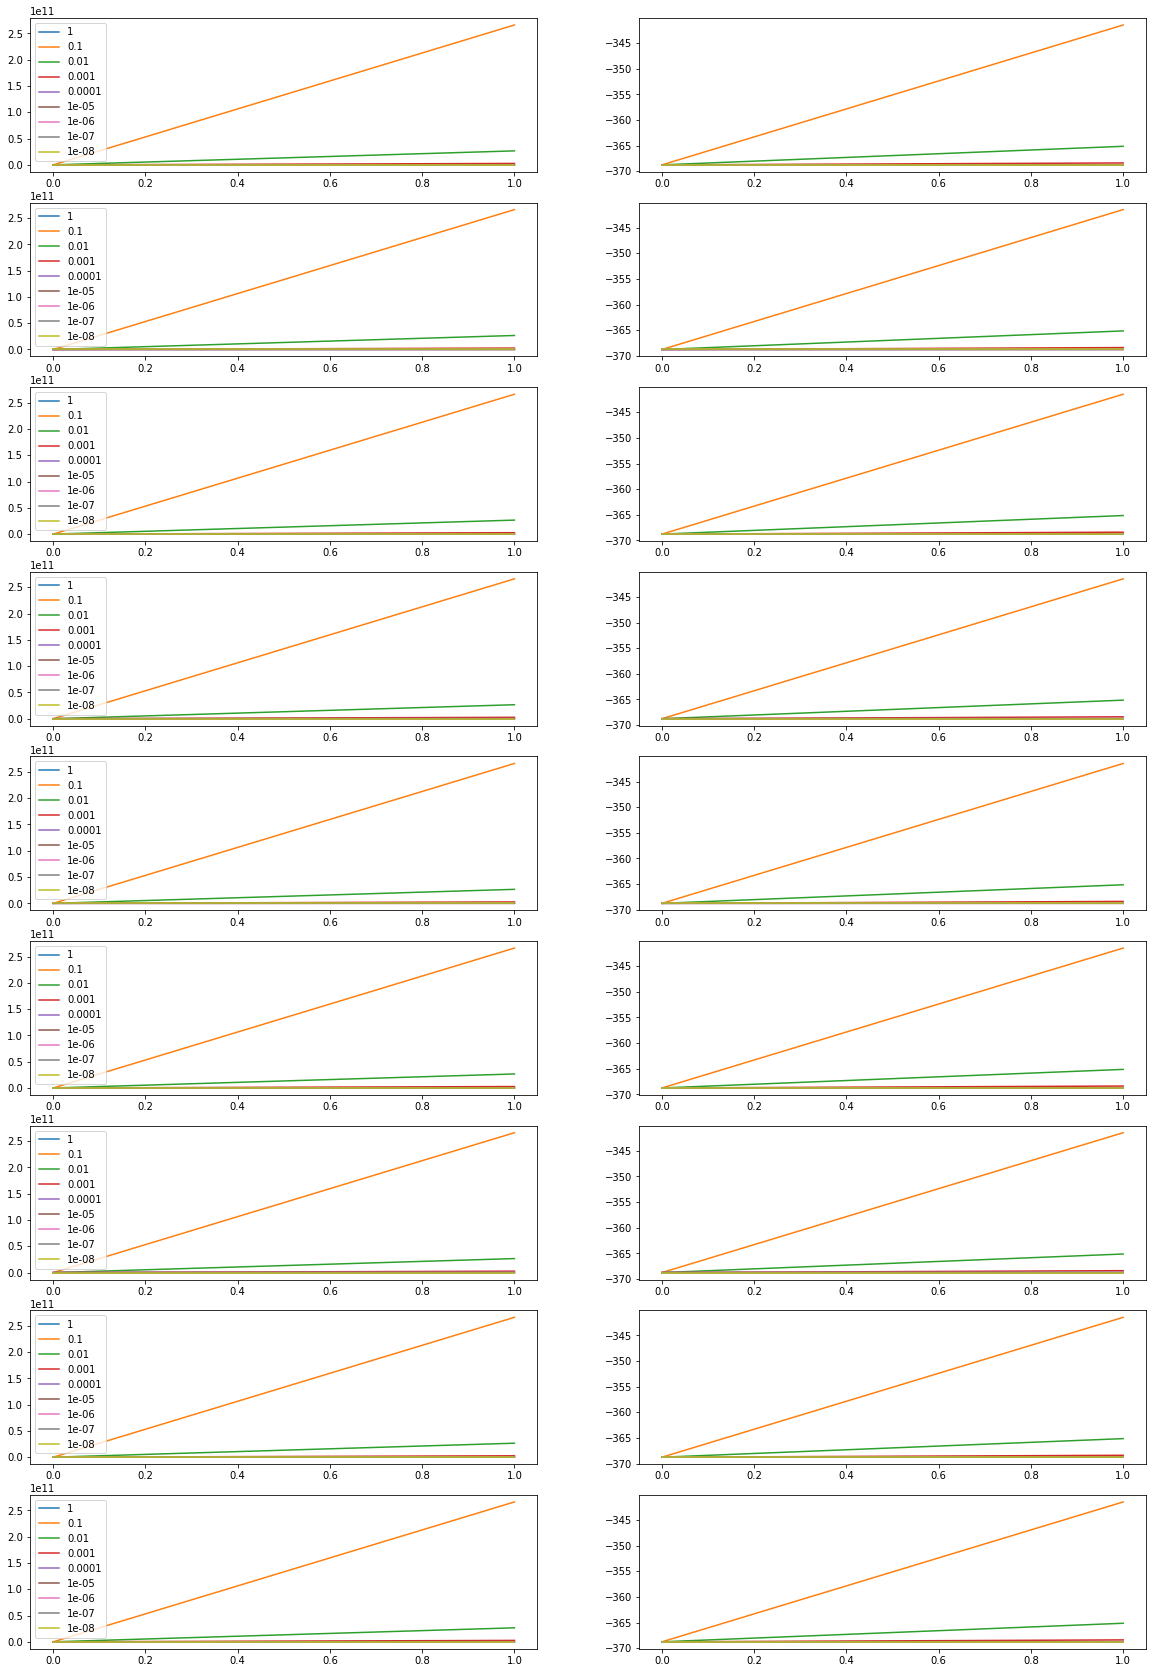

In [17]:
# Using a back boldriver stepsize controller  
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(20,30))
color = ['red','green','blue']
t = 9 
for max_iter in range(100, 1000, 100):
    mu = [10**-x for x in range(9)]
    for m in mu:
    
        weight2 ,toplot2, loss2 = learn_logreg_GA_adag(x = X_train ,y=Y_train, mu=m,max_iter=max_iter, \
                                  thresh=10**-6, intercep=True)
        lists = sorted(toplot2.items()) 
        list1 = sorted(loss2.items()) 
        x, y = zip(*lists)
        x1, y1 = zip(*list1)

        ax[9-t][0].plot(x, y, label=m)
        ax[9-t][1].plot(x1, y1)
        ax[9-t][0].legend(loc='best')
    t -=1

Conlusion: 
WE notice a Quick convergence with bolddriver. However due to the Change of the step size, we notice some deviatiom on the graph of the 

### Using Newton method

In [13]:
def W_diag(y_hat,btha):  
    return  np.multiply(y_hat, (1- y_hat))

def minimize_newton(x,y, mu,max_iter, thresh, intercep = False, btha_0=None):
    
    if intercep:                                     #adding the intercep to the X 
        ones = np.ones(x.shape[0]).reshape(-1,1)
        x    = np.hstack([ones, x])
    
    if btha_0 == None:
        btha_0 = np.zeros(x.shape[1]).reshape(-1,1)
    
    to_plot = {}
    logloss = {}
    for t in range(max_iter):
        loss_0 = loss_likelyhood(x,y,btha_0)
        logloss[t] = loss_0
        y_hat  = sigmoid(np.matmul(x, btha_0))
        
        grad   = np.dot(x.T, (y-y_hat))
        
        w = W_diag(y_hat,btha_0)
        
        H = np.dot(x.T, w*x)
        btha_nex = btha_0 + mu*np.dot(np.linalg.inv(H),grad)
        
        loss_nex = loss_likelyhood(x,y,btha_nex)
        to_plot[t] = abs(loss_nex-loss_0)
        if loss_nex - loss_0 < thresh:
            return to_plot, logloss
        
        btha_0 = btha_nex
    return  to_plot, logloss

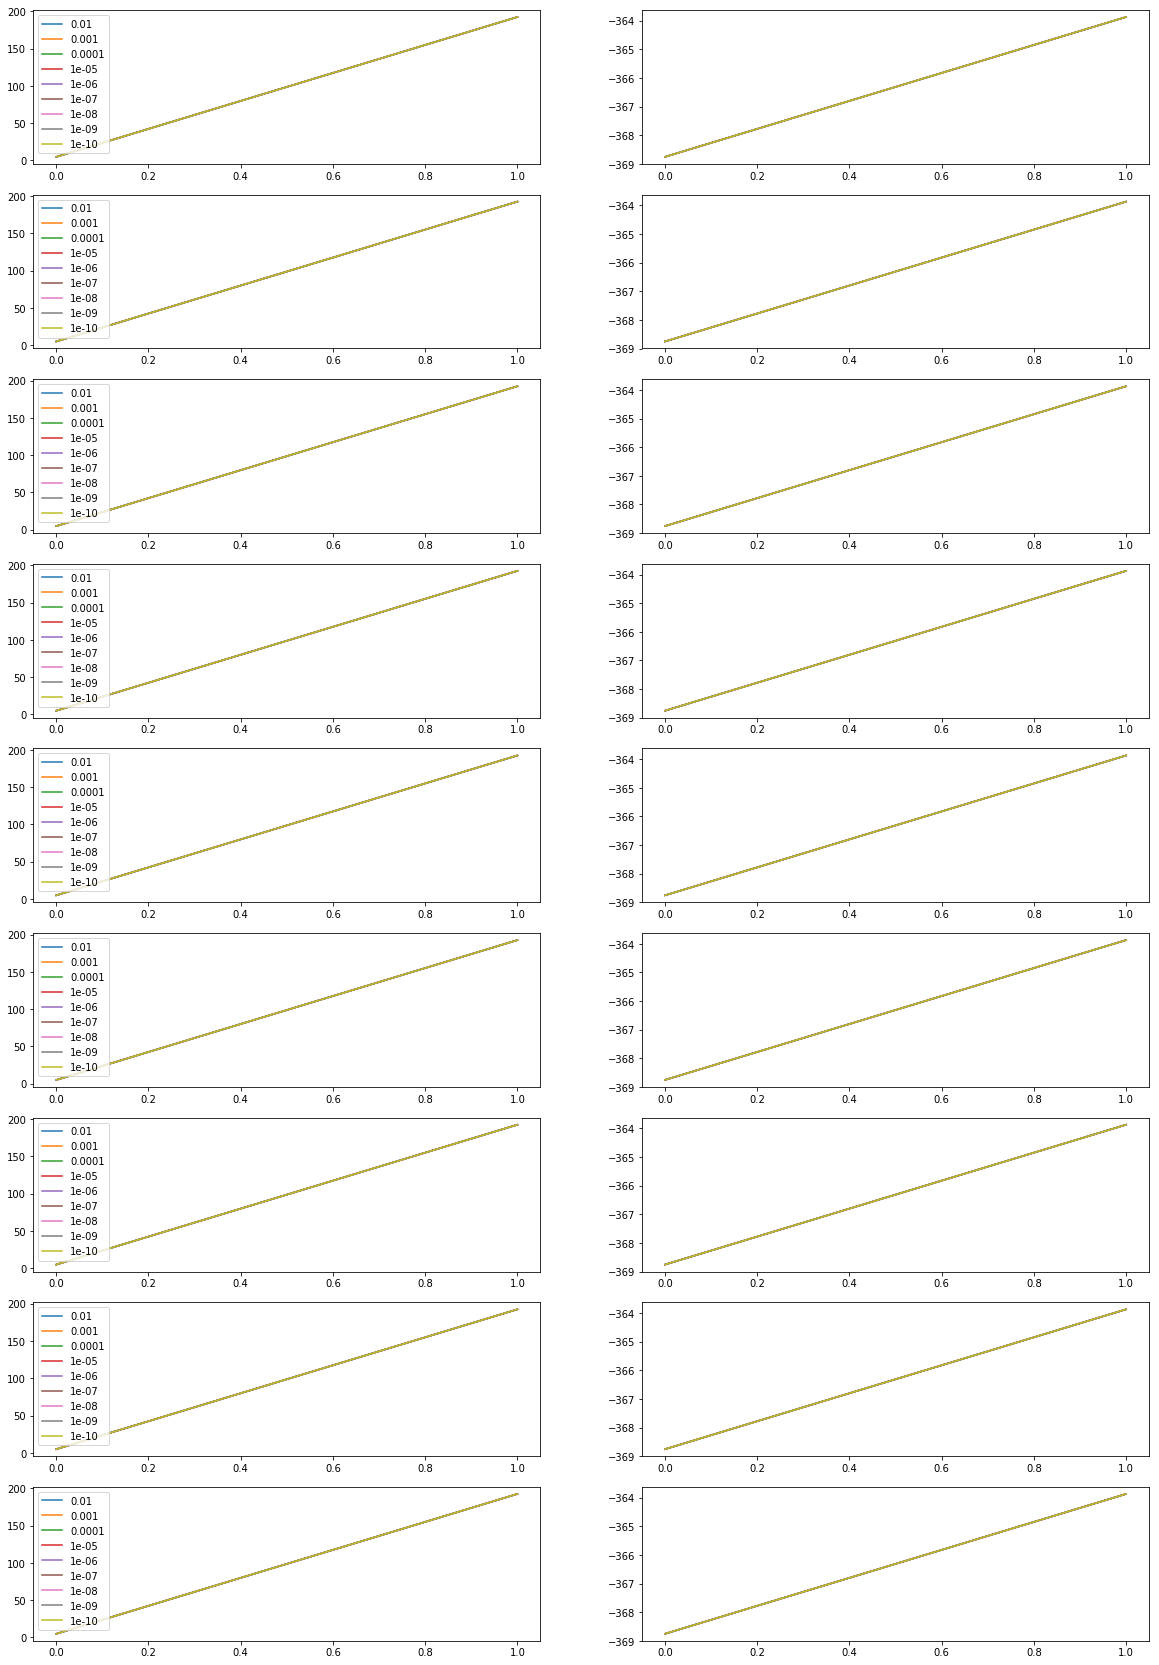

In [14]:
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(20,30))
color = ['red','green','blue']
t = 9 
for max_iter in range(100, 1000, 100):
    mu = [10**-x for x in range(2,11)]
    for m in mu:

        toplot, los =minimize_newton(x = X_train ,y=Y_train, mu=1,max_iter=max_iter, \
                                  thresh=10**-6, intercep=True)
        lists = toplot.items() 
        list1 = los.items()
        x, y = zip(*lists)
        x1, y1 = zip(*list1)

        ax[9-t][0].plot(x, y, label=m)
        ax[9-t][1].plot(x1, y1)
        ax[9-t][0].legend(loc='best')
    t -=1

Conclusion:
    We notice that with newton methode converge quick ly work with learnin rat 0.01 and then don converge with other learnin 

In [16]:

def pivot_research(A,B,j):
    
# =============================================================================
#     
#     N = np.array([[ 5,  6,  7,  8,  9],
#                   [ 0,  1,  2,  3,  4],
#                   [10, 11, 12, 13, 14],
#                   [15, 16, 17, 18, 19]])
#     
#     N[[3,0]]=N[[0,3]]
#     
#     N
#     Out[82]: 
#     array([[15, 16, 17, 18, 19],
#            [ 0,  1,  2,  3,  4],
#            [10, 11, 12, 13, 14],
#            [ 5,  6,  7,  8,  9]])
#     this function will swape the the given row=0 with row=3, 
#     
# =============================================================================
    row, col = A.shape
    p = j
    for i in range(j+1,row):
        if abs(A[i, j]) > abs(A[p,j]):
            p = i
    if p!= j:            # if the initial row is not the biggest
        A[[p,j]] = A[[j,p]] # we swape these two value 
        B[[p,j]] = B[[j,p]] # we swape 

        
def elim_low_triangle(A,B, j):
    "Eliminate the lower triangle value "
    row,_ = A.shape
    for i in range(j+1, row):
        B[i] = B[i]- (A[i,j]/A[j,j])*B[j]
        A[i] = A[i]- (A[i,j]/A[j,j])*A[j]
        
def descente(A, b):
    for j in range(A.shape[1]-1):
        recherche_pivot(A, b, j) 
        elimination_bas(A, b, j)   
def descent(A,B):
    "the return the descendent elimination of \
    the matrix"
    _,col = A.shape
    for k in range(col-1):             # iterate all the row 
        pivot_research(A,B,k)            # put the pivote on top of the selected matrix or submatrix
        elim_low_triangle(A,B,k)         # eliminate the lower part 
        
def elim_up_triangle(A,B,m):
    for i in range(m):
        B[i] = B[i] - (A[i,m]/A[m,m])*B[m]
        
def ascend(A,B):
    _,col = A.shape
    for i in range(col-1,0, -1):
        elim_up_triangle(A,B,i)
        
# after the above operation will have a diagonal matrix 
 
def diagonal(A,B):
    row = B.shape[0]
    for i in range(row):
        B[i] = B[i]/A[i,i]
    return B  # return the final result 

def Gauss(A,B):
    "This return the solution of our system"
    if A.dtype != 'float'or B.dtype != 'float': # this will raise a problem 
        A = A.astype('float')
        B = B.astype('float')
    # create a copy, this allow us to not change permently our inita=ial mtrices 
    R= A.copy()  
    V = B.copy()
    descent(R,V)
    ascend(R,V)
    return diagonal(R,V)     

In [17]:
def minimize_newton_gauss(x,y, mu,max_iter, thresh, intercep = False, btha_0=None):
    
    if intercep:                                     #adding the intercep to the X 
        ones = np.ones(x.shape[0]).reshape(-1,1)
        x    = np.hstack([ones, x])
    
    if btha_0 == None:
        btha_0 = np.zeros(x.shape[1]).reshape(-1,1)
    to_plot = {}
    logloss = {}
    for t in range(max_iter):
        loss_0 = loss_likelyhood(x,y,btha_0)
        logloss[t] = loss_0
        y_hat  = sigmoid(np.matmul(x, btha_0))
        
        grad   = partial(x,y,y_hat)
        
        w = W_diag(y_hat,btha_0)
        
        H = np.dot(x.T, w*x)   # the Hassian of the log loss funciton 
        sol = Gauss(H, grad)   # applying the gaussian( this is usefull when we can not compute the inverse )
        btha_nex = btha_0 + mu*sol
        
        loss_nex = loss_likelyhood(x,y,btha_nex)
        to_plot[t] = abs(loss_nex-loss_0)
        if loss_nex - loss_0 < thresh:
            return to_plot, logloss
        
        btha_0 = btha_nex
    return to_plot, logloss

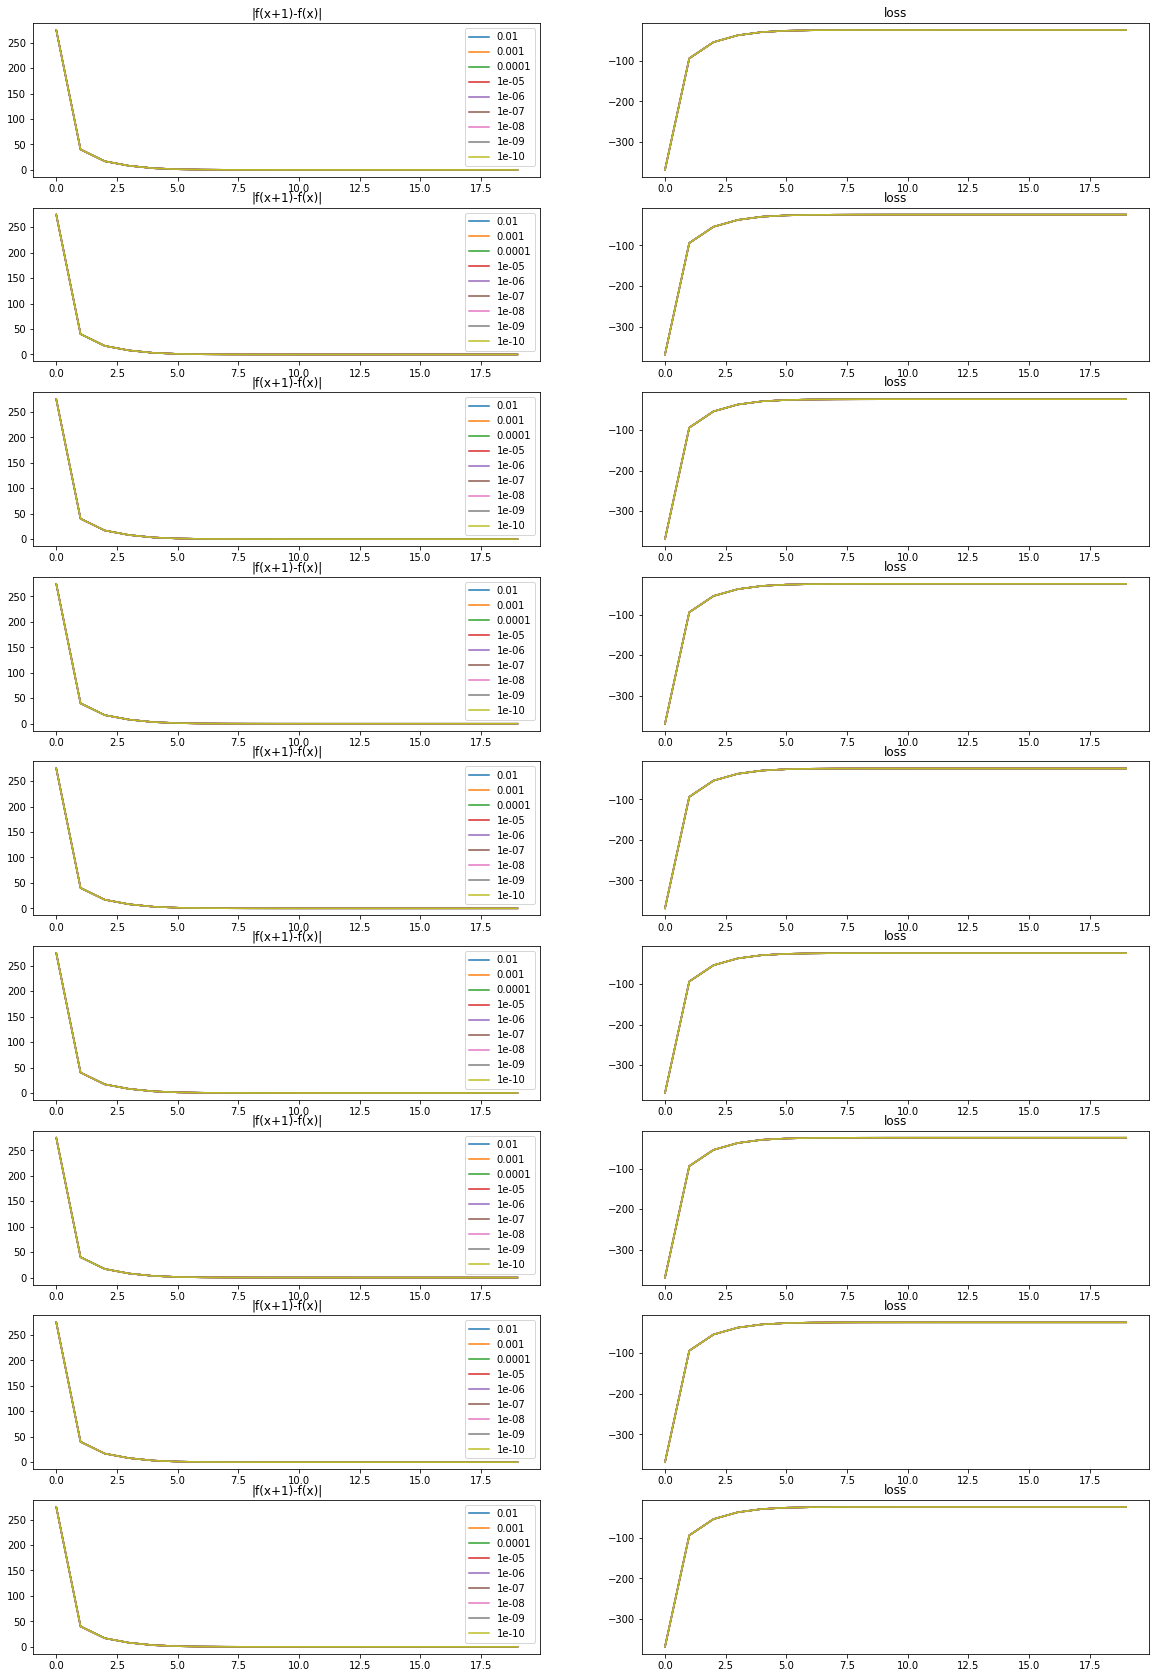

In [18]:
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(20,30))
color = ['red','green','blue']
t = 9 
for max_iter in range(100, 1000, 100):
    mu = [10**-x for x in range(2,11)]
    for m in mu:
        
        toplot, los =minimize_newton_gauss(x=X_train,y=Y_train, mu=1,max_iter=10000, thresh=10**-6,\
                                           intercep = True, btha_0=None)
                                   
        lists = toplot.items() 
        list1 = los.items()
        x, y = zip(*lists)
        x1, y1 = zip(*list1)

        ax[9-t][0].plot(x, y, label=m)
        ax[9-t][1].plot(x1, y1)
        ax[9-t][1].title.set_text('loss')
        ax[9-t][0].title.set_text('|f(x+1)-f(x)|')
        ax[9-t][0].legend(loc='best')
    t -=1

Conclusion: We notive a divergence, that is because the matrix of the training data set might not be inversible 
The Newton methode converge at around 5 iteration 